In [9]:
from Crypto.PublicKey import ECC
from Crypto.Cipher import AES
from Crypto.Protocol.KDF import HKDF
from Crypto.Hash import SHA256
import time
import numpy as np
import matplotlib.pyplot as plt

### Chave ECC

| Curva  | Segurança (bits) | Performance                 | Uso comum                                  |
|--------|------------------|-----------------------------|--------------------------------------------|
| P-192  | 96 bits          | Rápida, porém menos segura  | Obsoleta                                   |
| P-256  | 128 bits         | Muito bom equilíbrio        | ✅ Recomendado                              |
| P-384  | 192 bits         | Mais lenta                  | Ambientes que exigem maior segurança       |
| P-521  | 256 bits         | Muito lenta                 | Pouco usada na prática                     |

In [10]:
key = ECC.generate(curve='P-256') # curvas recomendadas pelo NIST
private_key = key # private_key é usada localmente para operações que exigem sigilo.
public_key = key.public_key() # public_key será usada na negociação da chave simétrica com a parte que quer se comunicar.

Porque a curva P-256?
* P-256 oferece um nível de segurança equivalente a uma chave RSA de 3072 bits. É mais que suficiente para garantir proteção contra ataques modernos.
* Mais rápidas (em geral) e mais eficientes em uso de memória

In [11]:
# Exporta as chaves ECC em formato legível (PEM) para reuso ou armazenamento seguro.
with open("ECIES_keys/ECC_256_private.pem", "wt") as f:
    f.write(private_key.export_key(format='PEM'))

with open("ECIES_keys/ECC_256public.pem", "wt") as f:
    f.write(public_key.export_key(format='PEM'))

# Criptografia

In [12]:
# Tempo de excecução
tempos_execucao = []
execucoes = []

for rodagem in range(218, 300): # Loop para os slices
    inicio = time.perf_counter()

    print(f'Iniciando criptografia ECIES: arquivo {rodagem}')

    dicom_path = f'C:\\Users\\CarlosChinen\\OneDrive\\Main\\FEI\\TCC\\Criptografia\\criptografia\\DATASET_dicom_fourier_spectrum\\spectrum_slice_{rodagem}.png'
    # dicom_path = f'C:\\Users\\massa\\OneDrive\\Main\\FEI\\TCC\\Criptografia\\criptografia\\DATASET_dicom_fourier_spectrum\\spectrum_slice_{rodagem}.png'

    with open(dicom_path, "rb") as dicom_file: # Lê os bytes da imagem do espectro.
        image_data = dicom_file.read() 

    # Negociação de chave com ECC (ECDH) - cria uma chave secreta compartilhada
    session_key = ECC.generate(curve='P-256') # chave ECC gerada temporariamente para esta sessão (chave de sessão).
    shared_secret = session_key.d * public_key.pointQ # Elliptic Curve Diffie-Hellman - a session_key multiplica a chave pública do receptor para gerar um secret compartilhado (ponto na curva elíptica).

    # Deriva uma chave AES a partir do segredo compartilhado
    shared_secret_bytes = int(shared_secret.x).to_bytes(32, byteorder='big') # Extrai o valor X do ponto da curva para gerar um número (convertido em 32 bytes).
    aes_key = HKDF(shared_secret_bytes, 32, b'', SHA256) # Usa o HKDF com SHA-256 para derivar uma chave AES forte e segura de 256 bits (32 bytes) a partir do segredo compartilhado.

    cipher_aes = AES.new(aes_key, AES.MODE_EAX) # Cria um objeto de cifra AES no modo EAX, que suporta confidencialidade + integridade.
    ciphertext, tag = cipher_aes.encrypt_and_digest(image_data) # encrypt_and_digest: criptografa os dados e gera um authentication tag para verificar integridade posteriormente.

    # Salva os componentes necessários para descriptografia:
    with open(f"ECIES_crypto_spectrum_metrics/ECIES_spectrum_criptografado_{rodagem}.enc", "wb") as out_file:
        out_file.write(session_key.public_key().export_key(format='DER')) # permite ao receptor refazer o segredo compartilhado.
        out_file.write(cipher_aes.nonce) # único por criptografia, necessário para decifrar no modo EAX.
        out_file.write(tag) # autenticação da mensagem.
        out_file.write(ciphertext) # os dados efetivamente criptografados.
    
    fim = time.perf_counter()
    tempo_execucao = fim - inicio
    tempos_execucao.append(tempo_execucao)
    execucoes.append(rodagem)

    print(f'Criptografia ECC finalizada: arquivo {rodagem}')
    print(f"Tempo de execução: {tempo_execucao:.5f} segundos\n")

print(f'\nTempo médio de execução: {np.mean(tempos_execucao):.5f}')

Iniciando criptografia ECIES: arquivo 218
Criptografia ECC finalizada: arquivo 218
Tempo de execução: 0.00352 segundos

Iniciando criptografia ECIES: arquivo 219
Criptografia ECC finalizada: arquivo 219
Tempo de execução: 0.00336 segundos

Iniciando criptografia ECIES: arquivo 220
Criptografia ECC finalizada: arquivo 220
Tempo de execução: 0.00247 segundos

Iniciando criptografia ECIES: arquivo 221
Criptografia ECC finalizada: arquivo 221
Tempo de execução: 0.00265 segundos

Iniciando criptografia ECIES: arquivo 222
Criptografia ECC finalizada: arquivo 222
Tempo de execução: 0.00272 segundos

Iniciando criptografia ECIES: arquivo 223
Criptografia ECC finalizada: arquivo 223
Tempo de execução: 0.00277 segundos

Iniciando criptografia ECIES: arquivo 224
Criptografia ECC finalizada: arquivo 224
Tempo de execução: 0.00306 segundos

Iniciando criptografia ECIES: arquivo 225
Criptografia ECC finalizada: arquivo 225
Tempo de execução: 0.00339 segundos

Iniciando criptografia ECIES: arquivo 22

### Resumo:
| Etapa           | Função                                                                                      |
|-----------------|---------------------------------------------------------------------------------------------|
| ECC Key Gen     | Gera chave pública/privada                                                                  |
| ECDH            | Deriva um segredo compartilhado via multiplicação de chave de sessão com chave pública do receptor |
| HKDF            | Deriva uma chave simétrica (AES) segura                                                     |
| AES-EAX         | Criptografa a imagem garantindo confidencialidade e integridade                             |
| Armazenamento   | Salva chave de sesssão, nonce, tag e criptograma para uso posterior na descriptografia         |


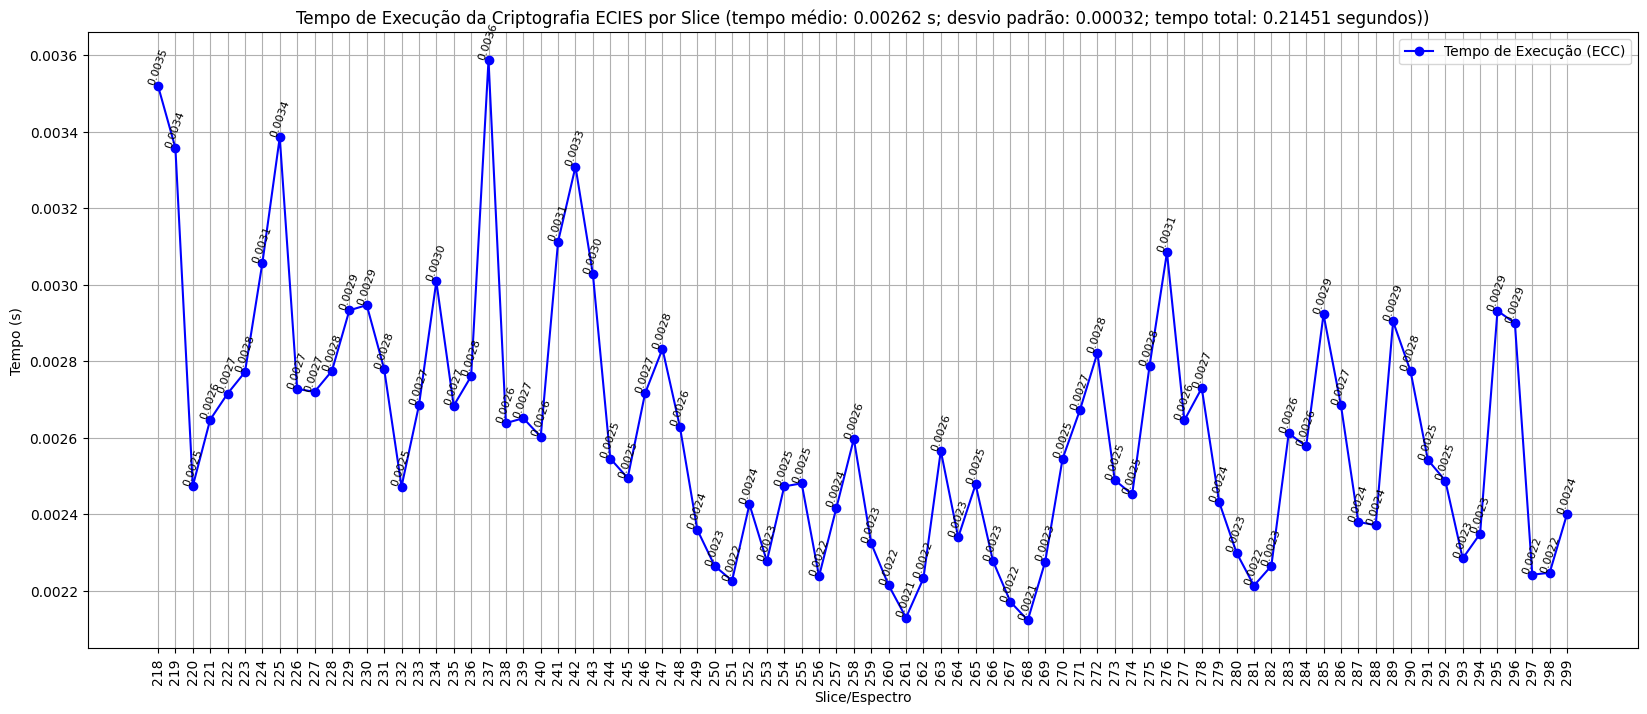

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(execucoes, tempos_execucao, marker='o', linestyle='-', color='blue', label='Tempo de Execução (ECC)')

for x, y in zip(execucoes, tempos_execucao):
    plt.text(x, y + 0.00005, f'{y:.4f}', ha='center', va='center', fontsize=8, rotation=70)

plt.xticks(execucoes, rotation=90)
plt.xlabel('Slice/Espectro')
plt.ylabel('Tempo (s)')
plt.title(f'Tempo de Execução da Criptografia ECIES por Slice (tempo médio: {np.mean(tempos_execucao):.5f} s; desvio padrão: {np.std(tempos_execucao, ddof=0):.5f}; tempo total: {np.sum(tempos_execucao):.5f} segundos))')
plt.legend()
plt.grid(True)
plt.savefig('output_images/graph_tempo_execucao_ecc_criptografia_espectro.png')
plt.show()